# 1. Prepare Data

In [1]:
sample_number = 5000
anomaly_ratio   = 0.2
test_size            = 0.5

signal_length    = 1024
Fs                     = 20480
rotate_fre         = 60
sigma               = 1
coeff_type        = [1,1]
from tools.SimulateDataset import data_prepare
data_dict = data_prepare(sample_number, anomaly_ratio, test_size, signal_length, rotate_fre, Fs, sigma, coeff_type)
import joblib
joblib.dump(data_dict,r'.\data\Simulated_dataset.pkl')

prepare train data...
prepare test data...


['.\\data\\Simulated_dataset.pkl']

# 2. Visualization

### Check samples

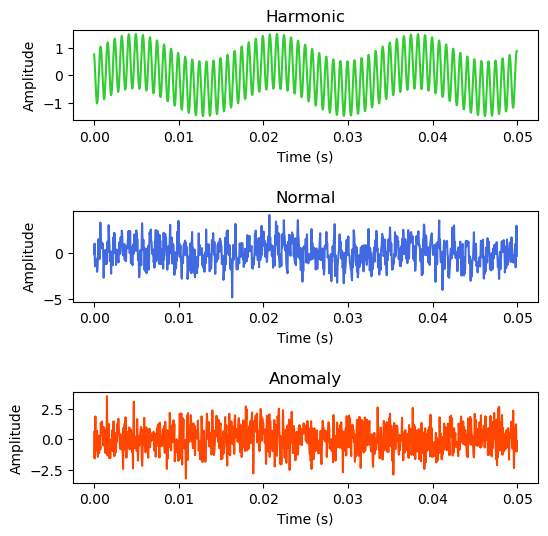

In [27]:
%matplotlib inline
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
data_dict = joblib.load(r'.\data\Simulated_dataset.pkl')

ground_truth      = data_dict['test_gth_1d'][1000,0]
normal_sample   = data_dict['test_1d'][1000,0]
anomaly_sample = data_dict['test_1d'][-1,0]

x = np.arange(0, 1024/20480, 1/20480)
y_list, title_list, mark_list = [ground_truth, normal_sample, anomaly_sample], ['Harmonic', 'Normal', 'Anomaly'], ['(a)', '(b)', '(c)']

figure = plt.figure(1,figsize=(6,6), dpi=100)
plt.subplots_adjust(hspace=1, wspace=0.2)
for i in range(3):
    plt.subplot(3,1,i+1)
    color = 'limegreen' if i == 0 else 'royalblue' if i==1 else 'orangered'
    plt.plot(x, y_list[i], color=color)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title_list[i])
plt.show()
figure.savefig(r'.\figure\normal_and_abnormal_samples.pdf',bbox_inches = 'tight')

### Load trained model

In [3]:
import os
import torch
import numpy as np
from tools.classify_result import classify_result
from model.AAU_Net import UnrolledAutoEncoder, Discriminator, parse_args

generator_path       = r'.\result\AAU_Net\model\model_epo_015_GLoss_0.8070_DLoss_0.0594_Generator.pth'
discrimimator_path = r'.\result\AAU_Net\model\model_epo_015_GLoss_0.8070_DLoss_0.0594_Discrim.pth'

opt = parse_args()
opt.use_cuda = False
opt.Tensor = torch.FloatTensor
generator = UnrolledAutoEncoder(opt)
discriminator = Discriminator(opt)
generator.load_state_dict(torch.load(generator_path,map_location='cpu'))
discriminator.load_state_dict(torch.load(discrimimator_path,map_location='cpu'))

data_path = r'.\data\Simulated_dataset.pkl'
data_dict = joblib.load(data_path)
input_x = torch.Tensor(data_dict['test_1d'])
input_y = data_dict['test_label']

x_hat, x_z = generator(input_x, test=True)
score = discriminator(x_z)
result = score.cpu().detach().numpy()
RI, TP, TN, FP, FN = classify_result(result, input_y, thres=0.5, print_result=False)

### Anomaly score distribution

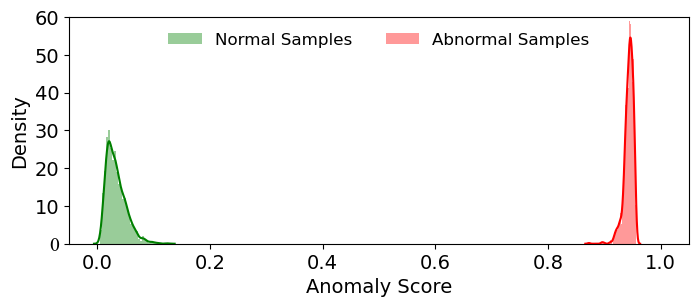

In [14]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
import seaborn as sns

figure = plt.figure(1,figsize=(8,3), dpi=100)
sns.distplot(pd.concat([TN, FP]).values[:,0],label='Normal Samples',color='g')
sns.distplot(pd.concat([TP, FN]).values[:,0],label='Abnormal Samples',color='r')
plt.xlabel('Anomaly Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.ylim([0, 60])
plt.xlim([-0.05,1.05])
plt.yticks(fontproperties = 'Times New Roman', fontsize = 14)
plt.xticks(fontproperties = 'Times New Roman', fontsize = 14)
plt.legend(fontsize=12, ncol=2,loc='upper center', frameon=False)
plt.show()
figure.savefig(r'.\figure\anomaly_score_distribution.pdf',bbox_inches = 'tight')

### Reconstruct overall feature

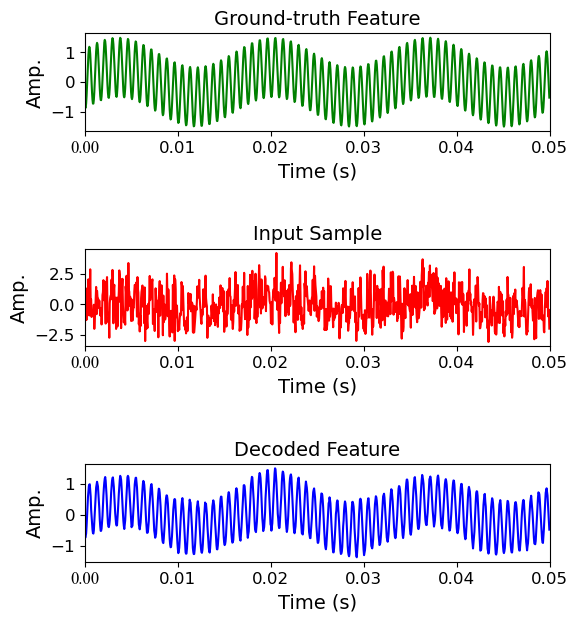

In [13]:
selected_samaple = 0

color_list = ['g','r','b']
title_list = ['Ground-truth Feature', 'Input Sample', 'Decoded Feature']
simulated_signal = [data_dict['test_gth_1d'], data_dict['test_1d'], x_hat.cpu().detach().numpy()]

figure = plt.figure(2,figsize=(6,7), dpi=100)
plt.subplots_adjust(hspace=1.2, wspace=0.3)
for i, signal in enumerate(simulated_signal):
    plt.subplot(3,1,i+1)
    plt.plot(x, signal[selected_samaple].flatten(), color=color_list[i])
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amp.', fontsize=14)
    plt.yticks(fontproperties = 'Times New Roman', fontsize = 12)
    plt.xticks(fontproperties = 'Times New Roman', fontsize = 12)
    plt.xlim([0, 0.05])
    plt.title(title_list[i], fontsize=14)
plt.show()
figure.savefig(r'.\figure\reconstruct_overall_feature.pdf',bbox_inches = 'tight')

### Visualize atom feature

In [15]:
from tools.CalConvDict import GenConvDict

ParaDict = torch.load(generator_path, map_location='cpu')
MatrixName = ['W1','W2','W3','W4']
Dict = GenConvDict(opt, ParaDict, MatrixName)
ConvMatrix, SigLengthList = Dict.GenConvMatrix()
KernelLength, StrideLength = Dict.CalKernelLen()
D1, D2, D3, D4 = ConvMatrix['W1'], ConvMatrix['W2'], ConvMatrix['W3'], ConvMatrix['W4']
D12 = D1.dot(D2)
D123 = D12.dot(D3)
D1234 = D123.dot(D4)

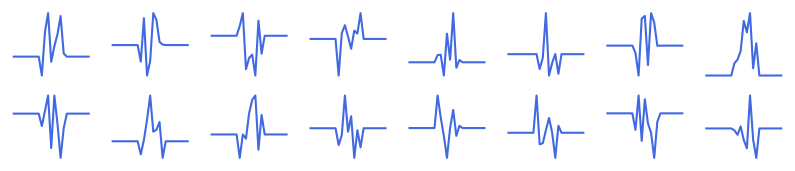

In [23]:
# visualize D1
import matplotlib.pyplot as plt
plt.subplots(figsize=(10, 2), dpi=100)
cols_skip = D1.shape[1]//opt.CL[0]
cols_loca = cols_skip//2
for i in range(16):
    ax = plt.subplot(2,8,i+1)
    ax.plot(D1[512-11:512+14,i*cols_skip+cols_loca],'royalblue',linewidth=1.5)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.show()

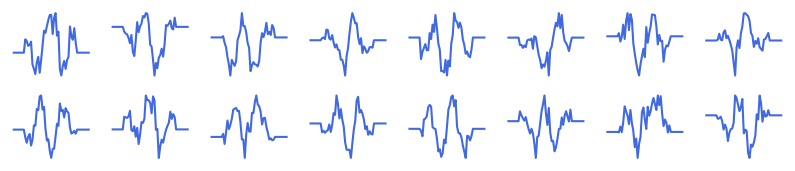

In [24]:
# visualize D12
import matplotlib.pyplot as plt
fig = plt.subplots(figsize=(10, 2), dpi=100)
cols_skip = D12.shape[1]//opt.CL[1]
cols_loca = cols_skip//2
for i in range(16):
    ax = plt.subplot(2,8,i+1)
    plt.plot(D12[512-18:512+35,i*cols_skip+cols_loca], 'royalblue',linewidth=1.5)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.show()

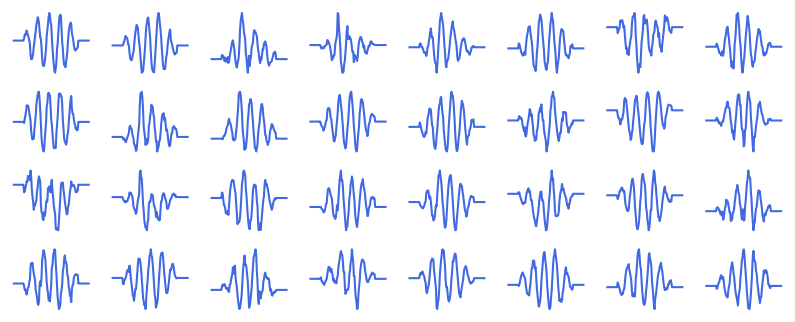

In [25]:
# visualize D123
import matplotlib.pyplot as plt
plt.subplots(figsize=(10, 4), dpi=100)
cols_skip = D123.shape[1]//opt.CL[2]
cols_loca = cols_skip//2
for i in range(32):
    ax = plt.subplot(4,8,i+1)
    plt.plot(D123[512-42:512+75,i*cols_skip+cols_loca], 'royalblue',linewidth=1.5)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.show()

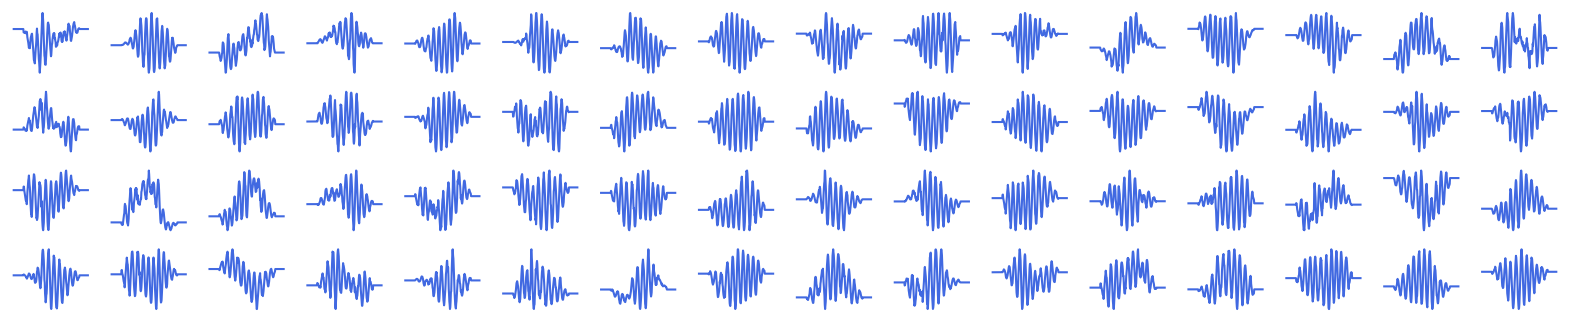

In [26]:
# visualize D1234
import matplotlib.pyplot as plt
plt.subplots(figsize=(20, 4), dpi=100)
cols_skip = D1234.shape[1]//opt.CL[3]
cols_loca = cols_skip//2
for i in range(64):
    ax = plt.subplot(4,16,i+1)
    plt.plot(D1234[512-90:512+150,i*cols_skip+cols_loca], 'royalblue',linewidth=1.5)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.show()